In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import numpy as np
import glob
import math
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches


## Identifying Close Games
#### After the 6th inning if one of the following is true marked as a close game
- Tie game
- Score within 1 run
- Lead change between 7-9 innings


In [233]:

FOLDER = "/Users/lancesanterre/interview/data_aq/team_scenarios"

files = glob.glob(os.path.join(FOLDER, "*.csv"))

total_games = 0
total_close_late = 0

per_file_rows = []

for file in files:
    df = pd.read_csv(file)

    for c in ["team_runs_6","opp_runs_6","team_runs_7_9","opp_runs_7_9"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    diff_after_6 = (df["team_runs_6"] - df["opp_runs_6"]).abs()
    team_final = df["team_runs_6"] + df["team_runs_7_9"]
    opp_final  = df["opp_runs_6"]  + df["opp_runs_7_9"]
    diff_final = (team_final - opp_final).abs()

    lead_after_6 = np.sign(df["team_runs_6"] - df["opp_runs_6"])
    lead_final   = np.sign(team_final - opp_final)
    lead_changed_late = lead_after_6 != lead_final

    close_late = (diff_after_6 <= 1) | (diff_final <= 1) | (lead_changed_late)

    games = len(df)
    close_ct = int(close_late.sum())

    total_games += games
    total_close_late += close_ct

    per_file_rows.append({
        "file": os.path.basename(file),
        "games": games,
        "close_late_games": close_ct,
        "close_late_pct": close_ct / games if games else np.nan
    })

per_file = pd.DataFrame(per_file_rows).sort_values("close_late_pct", ascending=False)


overall_pct = (total_close_late / total_games) * 100 if total_games else float("nan")

if "year" in df.columns:

    combined = []
    for file in files:
        d = pd.read_csv(file)
        for c in ["team_runs_6","opp_runs_6","team_runs_7_9","opp_runs_7_9"]:
            d[c] = pd.to_numeric(d[c], errors="coerce").fillna(0)
        da6 = (d["team_runs_6"] - d["opp_runs_6"]).abs()
        tf  = d["team_runs_6"] + d["team_runs_7_9"]
        of  = d["opp_runs_6"]  + d["opp_runs_7_9"]
        dfinal = (tf - of).abs()
        la6 = np.sign(d["team_runs_6"] - d["opp_runs_6"])
        lf  = np.sign(tf - of)
        leadflip = la6 != lf
        d["close_late"] = (da6 <= 1) | (dfinal <= 1) | (leadflip)
        combined.append(d[["year","close_late"]])
    big = pd.concat(combined, ignore_index=True)
    by_year = (big.groupby("year")["close_late"].mean() * 100).round(2)



In [234]:
arr = np.array(by_year)

mean_val = np.mean(arr)
std_val = np.std(arr, ddof=0)   
var_val = np.var(arr, ddof=0)  

print(f"Mean: {mean_val:.2f}")
print(f"Standard Deviation: {std_val:.2f}")
print(f"Variance: {var_val:.2f}")

Mean: 47.60
Standard Deviation: 1.71
Variance: 2.91


##### From 2011-2024 47.6% of MLB games were close after the 6th inning

### Calculating LGCI & Testing for Significance
$$
\text{LGCI} =
\frac{
\sum_{i=1}^{n} \text{Comeback Wins}_i
}{
\sum_{i=1}^{n} \text{Comeback Opportunities}_i
}$$
#### We use a significance level of α = 0.05 to determine whether a team's LGCI is statistically different from the league average.


In [235]:
folder_path = "/Users/lancesanterre/interview/data_aq/team_data/all_teams_yearly_summary.csv"
data_team = pd.read_csv(folder_path)

# making sure we catch Na values 
data_team["comeback_wins"] = pd.to_numeric(data_team["comeback_wins"], errors="coerce").fillna(0)
data_team["is_comeback_scenario"] = pd.to_numeric(data_team["is_comeback_scenario"], errors="coerce").fillna(0)

# calucalting LGCI
data_team["LGCI"] = data_team.apply(
    lambda x: x["comeback_wins"] / x["is_comeback_scenario"] if x["is_comeback_scenario"] > 0 else None,
    axis=1
)

# sorting by LGCI
data_team = data_team.sort_values(['LGCI'],ascending=False)
print("Best LGCI")
print(
    data_team[["team", "year", "final_win","LGCI"]]
    .head(10)
    .to_string(index=False, formatters={"LGCI": "{:.3f}".format}))
print("Worst LGCI")
print(
    data_team[["team", "year","final_win" ,"LGCI"]]
    .tail(10)
    .to_string(index=False, formatters={"LGCI": "{:.3f}".format}))

def two_prop_ztest(count1, n1, count2, n2):
    if n1 == 0 or n2 == 0:
        return np.nan, np.nan
    p1 = count1 / n1
    p2 = count2 / n2
    p_pool = (count1 + count2) / (n1 + n2)
    denom = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if denom == 0:
        return np.nan, np.nan
    z = (p1 - p2) / denom
    cdf = 0.5 * (1 + math.erf(abs(z) / math.sqrt(2)))
    p = 2 * (1 - cdf)
    return z, p
sig_list = []
alpha = 0.05

for _, row in data_team.iterrows():
    team = row["team"]
    c1, n1 = row["comeback_wins"], row["is_comeback_scenario"]

    others = data_team[data_team["team"] != team]
    c2, n2 = others["comeback_wins"].sum(), others["is_comeback_scenario"].sum()

    z, p = two_prop_ztest(c1, n1, c2, n2)

    if np.isnan(p):
        sig = 0
    elif p < alpha:
        if c1/n1 > c2/n2:
            sig = 1   # significantly above average
        else:
            sig = -1  # significantly below average
    else:
        sig = 0     # not significant

    sig_list.append(sig)

data_team["LGCI_sig"] = sig_list

Best LGCI
team  year  final_win  LGCI
 LAD  2020         43 0.312
  SF  2021        107 0.280
 LAD  2019        106 0.269
 CIN  2012         97 0.262
  TB  2021        100 0.259
 PHI  2011        102 0.259
 DET  2024         86 0.250
 MIN  2023         87 0.242
 HOU  2017        101 0.241
 CLE  2023         76 0.240
Worst LGCI
team  year  final_win  LGCI
  KC  2022         65 0.037
 MIA  2020         28 0.037
 HOU  2013         51 0.037
 BOS  2020         24 0.036
 LAD  2014         94 0.036
 BAL  2018         47 0.032
 CLE  2016         69 0.029
 WSN  2021         65 0.027
 WSN  2020         26 0.000
 CHW  2024         41 0.000


### Now that we know if they are Significant lets chart the top ten teams/year and ten worst

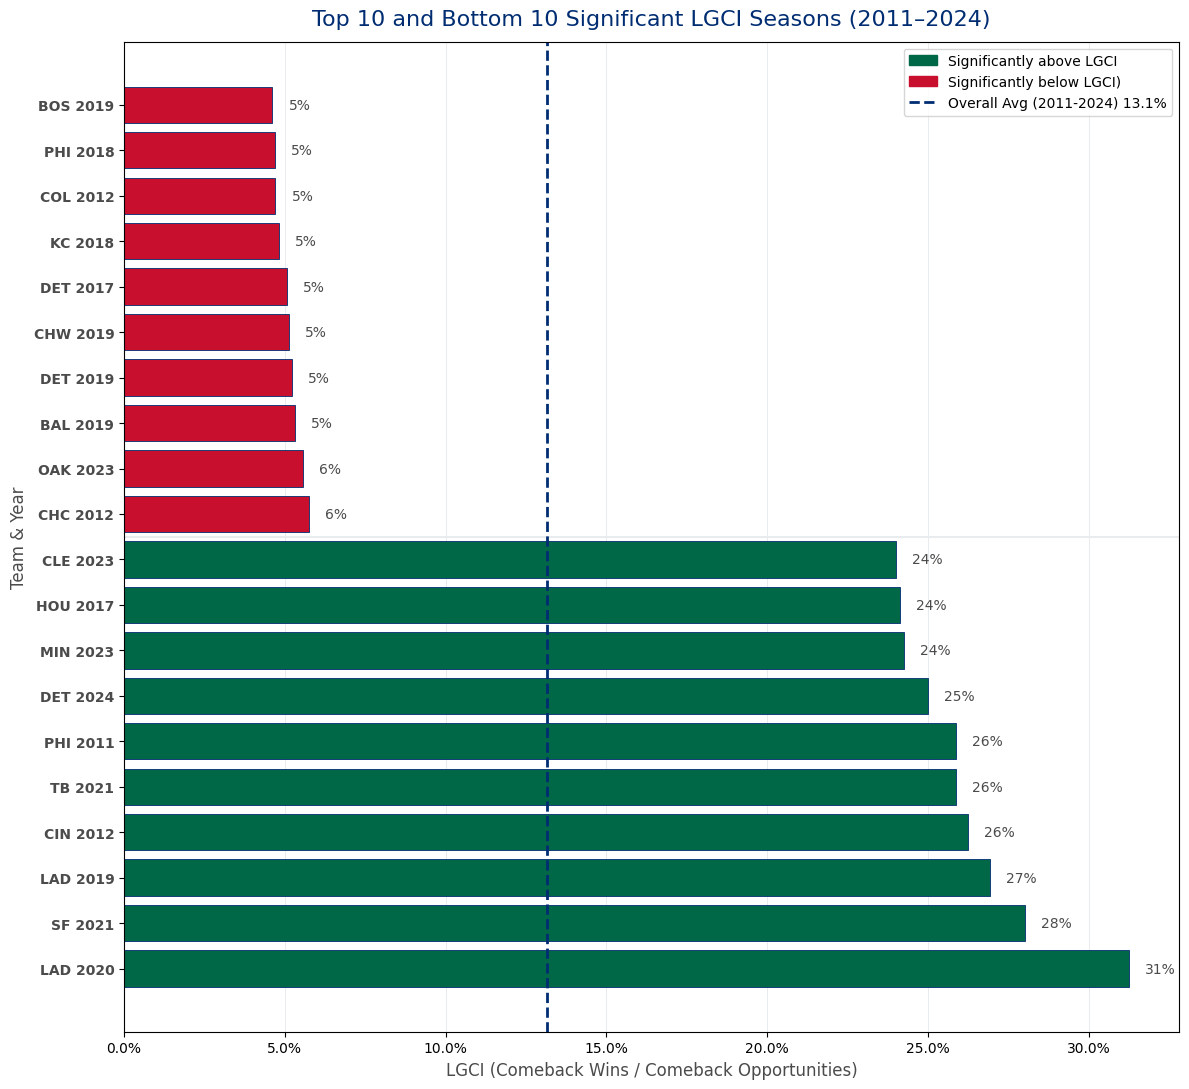

In [236]:
NAVY = "#002D72"
RED = "#C8102E"
GREEN = "#006747"
LTGRAY = "#E9ECEF"
DARKGRAY = "#4B4B4B"
WHITE = "#FFFFFF"

# Basic validation
required_cols = {"team", "year", "LGCI", "LGCI_sig"}

# Ensure types
data_team = data_team.copy()
data_team["LGCI"] = pd.to_numeric(data_team["LGCI"], errors="coerce")
data_team["LGCI_sig"] = pd.to_numeric(data_team["LGCI_sig"], errors="coerce")
data_team = data_team.dropna(subset=["LGCI"])

# Calculate overall average LGCI
overall_mean = data_team["LGCI"].mean()

# Filter significant seasons
sig_pos = data_team[data_team["LGCI_sig"] == 1].copy()  # Significantly above average
sig_neg = data_team[data_team["LGCI_sig"] == -1].copy()  # Significantly below average

# Select top and bottom 10 seasons
top10 = sig_pos.sort_values("LGCI", ascending=False).head(10)
bot10 = sig_neg.sort_values("LGCI", ascending=False).head(10)  # Changed to descending for bottom 10

# Create labels for plotting
top10["label"] = top10["team"].astype(str) + " " + top10["year"].astype(str)
bot10["label"] = bot10["team"].astype(str) + " " + bot10["year"].astype(str)

# Combine data and assign colors
plot_df = pd.concat([top10, bot10], axis=0).reset_index(drop=True)
plot_df["color"] = np.where(plot_df["LGCI_sig"] == 1, GREEN, RED)

# ---- Plot Configuration ----
fig_height = max(6, 0.45 * len(plot_df) + 2)
fig, ax = plt.subplots(figsize=(12, fig_height), facecolor=WHITE)
ax.set_axisbelow(True)
ax.grid(axis="x", color=LTGRAY, linewidth=0.7)

# Plot horizontal bars with larger bars at top descending
y_positions = np.arange(len(plot_df))
ax.barh(y_positions, plot_df["LGCI"], color=plot_df["color"], edgecolor=NAVY, linewidth=0.6)

# Set y-axis labels
ax.set_yticks(y_positions)
ax.set_yticklabels(plot_df["label"], color=DARKGRAY, fontsize=10,fontweight="bold")

# Add value labels on bars
for i, val in enumerate(plot_df["LGCI"]):
    ax.text(val + 0.005, i, f"{val:.0%}", va="center", ha="left", fontsize=10, color=DARKGRAY)

# Add separator between top and bottom teams
if len(top10) > 0 and len(bot10) > 0:
    ax.axhline(len(top10) - 0.5, color=LTGRAY, linewidth=1.5, label="Top/Bottom Divider")

# Add overall average line
ax.axvline(overall_mean, color=NAVY, linestyle="--", linewidth=2,
                      label=f"Overall Avg (2011–2024): {overall_mean:.1%}")
# Customize axes and titles
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("LGCI (Comeback Wins / Comeback Opportunities)", color=DARKGRAY, fontsize=12)
ax.set_ylabel("Team & Year", color=DARKGRAY, fontsize=12)
ax.set_title("Top 10 and Bottom 10 Significant LGCI Seasons (2011–2024)", fontsize=16, color=NAVY, pad=12)

legend_patches = [
    mpatches.Patch(color=GREEN, label="Significantly above LGCI"),
    mpatches.Patch(color=RED, label="Significantly below LGCI)"),
]
ax.legend(handles=legend_patches + [plt.Line2D([0], [0], color=NAVY, lw=2, ls="--", label=f"Overall Avg (2011-2024) {overall_mean:.1%}")],
          frameon=True, loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()

### Lets Look at the top teams wins and the bottom team losses

In [237]:
data_team['win_p'] = data_team['final_win']/data_team["total_games"]
corr_value = data_team['LGCI'].corr(data_team['win_p'], method='pearson')
print(f"Pearson correlation between LGCI and Win%: {corr_value:.3f}")

Pearson correlation between LGCI and Win%: 0.637


#### How Often Did Division Winners Have a Significantly Higher LGCI? (2011–2024)

In [238]:
folder_path = "/Users/lancesanterre/interview/mlb_division_winners_2011_2024.csv"
winners = pd.read_csv(folder_path)

winners_long = winners.melt(id_vars=["Year"], value_name="winner_name") \
                        .drop(columns=["variable"])

team_map = {
    "NYY": "Yankees", "BOS": "Red Sox", "TBR": "Rays", "TOR": "Blue Jays", "BAL": "Orioles",
    "CLE": "Guardians", "CHW": "White Sox", "DET": "Tigers", "KCR": "Royals", "MIN": "Twins",
    "HOU": "Astros", "TEX": "Rangers", "LAA": "Angels", "OAK": "Athletics",
    "ATL": "Braves", "NYM": "Mets", "PHI": "Phillies", "WSN": "Nationals", "MIA": "Marlins",
    "CHC": "Cubs", "STL": "Cardinals", "MIL": "Brewers", "CIN": "Reds", "PIT": "Pirates",
    "LAD": "Dodgers", "SFG": "Giants", "ARI": "Diamondbacks", "SDP": "Padres", "COL": "Rockies"
}

# Fix CLE name for pre-2022
def map_team(abbrev, year):
    if abbrev == "CLE" and year < 2022:
        return "Indians"
    return team_map.get(abbrev, abbrev)

preds = data_team[data_team["LGCI_sig"] == 1][["team", "year"]].copy()
preds["team_name"] = preds.apply(lambda r: map_team(r["team"], r["year"]), axis=1)

preds = preds.merge(winners_long, left_on=["year", "team_name"], right_on=["Year", "winner_name"], how="left")
preds["correct"] = preds["winner_name"].notna()

# --- Score ---
accuracy = preds["correct"].mean()
print("Precentage of Division Winners with Significant LGCI Advantage (2011–2024)")
print(f"Correct Picks: {preds['correct'].sum()} / {len(preds)} ({accuracy:.1%})")



Precentage of Division Winners with Significant LGCI Advantage (2011–2024)
Correct Picks: 13 / 23 (56.5%)


**Insight:** From 2011–2024, teams with a significantly higher LGCI won their division 56.5% of the time.


In [239]:
top_bottom_per_year = []

for year, group in data_team.groupby("year"):
    group_sorted = group.sort_values("LGCI", ascending=False)
    
    top_team = group_sorted.iloc[0]
    bottom_team = group_sorted.iloc[-1]
    
    top_bottom_per_year.append({
        "year": year,
        "top_team": top_team["team"],
        "top_team wins": top_team['final_win'],
        "top_LGWPI_weighted": top_team["LGCI"],
        "bottom_team": bottom_team["team"],
        "bottom_team wins": bottom_team['final_win'],
        "bottom_LGWPI_weighted": bottom_team["LGCI"]
    })

# Create DataFrame for display
top_bottom_df = pd.DataFrame(top_bottom_per_year)

In [240]:
top_bottom_df

,year,top_team,top_team wins,top_LGWPI_weighted,bottom_team,bottom_team wins,bottom_LGWPI_weighted
0,2011,PHI,102,0.258621,HOU,56,0.060241
1,2012,CIN,97,0.262295,COL,64,0.047059
2,2013,BAL,85,0.215385,HOU,51,0.037037
3,2014,WSN,96,0.205882,LAD,94,0.035714
4,2015,STL,100,0.206897,WSN,83,0.051724
5,2016,TEX,95,0.214286,CLE,69,0.029412
6,2017,HOU,101,0.241379,DET,63,0.050633
7,2018,MIL,96,0.222222,BAL,47,0.031579
8,2019,LAD,106,0.269231,BOS,84,0.046154
9,2020,LAD,43,0.312500,WSN,26,0.000000


### Calculating LGWPI & Testing for Significance

$$
\text{LGWPI} =
\frac{
\sum_{i=1}^{n} \left( \text{Comeback Wins}_i + \text{Held Games}_i \right)
}{
\sum_{i=1}^{n} \left( \text{Comeback Opportunities}_i + \text{Leads of 1 or 2 Runs After the 6th}_i \right)
}
$$

#### We use a significance level of α = 0.05 to determine whether a team's LGWPI is statistically different from the league average.


In [241]:
folder_path = "/Users/lancesanterre/interview/data_aq/team_data/all_teams_yearly_summary.csv"
data_team = pd.read_csv(folder_path)

num_cols = ["comeback_wins", "held_game", "is_comeback_scenario", "lead_1_2_runs_6th", "final_win"]
for c in num_cols:
    if c not in data_team.columns:
        raise KeyError(f"Missing required column: {c}")
    data_team[c] = pd.to_numeric(data_team[c], errors="coerce").fillna(0)


CW = data_team["comeback_wins"]          # comeback wins
HG = data_team["held_game"]              # held games
CO = data_team["is_comeback_scenario"]   # comeback opportunities
HO = data_team["lead_1_2_runs_6th"]      # hold opportunities (lead by 1–2 after 6th)

# --- Weighting ---
w_CW = 1   # weight for comeback wins
w_HG = 1   # weight for held games

# Weighted LGWPI formula
den = CO + HO
num = (w_CW * CW) + (w_HG * HG)
data_team["LGWPI_weighted"] = np.where(den > 0, num / den, np.nan)

# Sort results
data_team_sorted = data_team.sort_values(["LGWPI_weighted"], ascending=False, na_position="last")

print("Best Weighted LGWPI")
print(
    data_team_sorted[["team", "year", "final_win", "comeback_wins", "held_game", "LGWPI_weighted"]]
      .head(10)
      .to_string(index=False,
                 formatters={"LGWPI_weighted": "{:.3f}".format})
)

print("\nWorst Weighted LGWPI")
print(
    data_team_sorted[["team", "year", "final_win", "comeback_wins", "held_game", "LGWPI_weighted"]]
      .tail(10)
      .to_string(index=False,
                 formatters={"LGWPI_weighted": "{:.3f}".format})
)
# --- Build year-relative significance for LGWPI_weighted ---

w_CW, w_HG = 1.0, 1.0
alpha = 0.05

for c in ["comeback_wins","held_game","is_comeback_scenario","lead_1_2_runs_6th"]:
    data_team[c] = pd.to_numeric(data_team[c], errors="coerce").fillna(0)

# Weighted successes/trials per team-year row
data_team["w_success"] = w_CW*data_team["comeback_wins"] + w_HG*data_team["held_game"]
data_team["w_trials"]  = w_CW*data_team["is_comeback_scenario"] + w_HG*data_team["lead_1_2_runs_6th"]

# LGWPI_weighted value (for plotting)
den = (data_team["is_comeback_scenario"] + data_team["lead_1_2_runs_6th"])
num = (w_CW*data_team["comeback_wins"] + w_HG*data_team["held_game"])
data_team["LGWPI_weighted"] = np.where(den > 0, num/den, np.nan)

# League totals per YEAR
yr_totals = (data_team.groupby("year")[["w_success","w_trials"]]
                        .sum(numeric_only=True)
                        .rename(columns={"w_success":"yr_success","w_trials":"yr_trials"}))
df = data_team.merge(yr_totals, on="year", how="left")

# Helper (uses your existing two_prop_ztest)
def safe_z(c1,n1,c2,n2):
    if n1 <= 0 or n2 <= 0: return np.nan, np.nan
    return two_prop_ztest(c1, n1, c2, n2)

# Compute significance vs league-minus-team for that year
sig_year, z_list, p_list = [], [], []
for _, r in df.iterrows():
    c1, n1 = float(r["w_success"]), float(r["w_trials"])
    c2, n2 = float(r["yr_success"] - c1), float(r["yr_trials"] - n1)
    z, p = safe_z(c1, n1, c2, n2)
    z_list.append(z); p_list.append(p)
    if np.isnan(p): s = 0
    elif p < alpha: s = 1 if (c1/n1) > (c2/n2) else -1
    else: s = 0
    sig_year.append(s)

df["LGWPI_weighted_z_year"]   = z_list
df["LGWPI_weighted_p_year"]   = p_list
df["LGWPI_weighted_sig_year"] = sig_year

data_team = df


Best Weighted LGWPI
team  year  final_win  comeback_wins  held_game LGWPI_weighted
  KC  2014         89             11         26          0.366
 OAK  2020         36              6          9          0.366
  TB  2012         90              9         26          0.350
 TEX  2016         95             15         21          0.350
 LAD  2019        106             14         16          0.349
 NYY  2022         99             11         19          0.345
 SEA  2023         88             12         22          0.333
 STL  2020         30              4          7          0.333
 CHC  2018         95             12         21          0.327
 SEA  2018         89             13         20          0.327

Worst Weighted LGWPI
team  year  final_win  comeback_wins  held_game LGWPI_weighted
 CIN  2022         62              6          7          0.121
 DET  2019         47              5         10          0.119
 COL  2012         64              4          9          0.116
 CLE  2016   

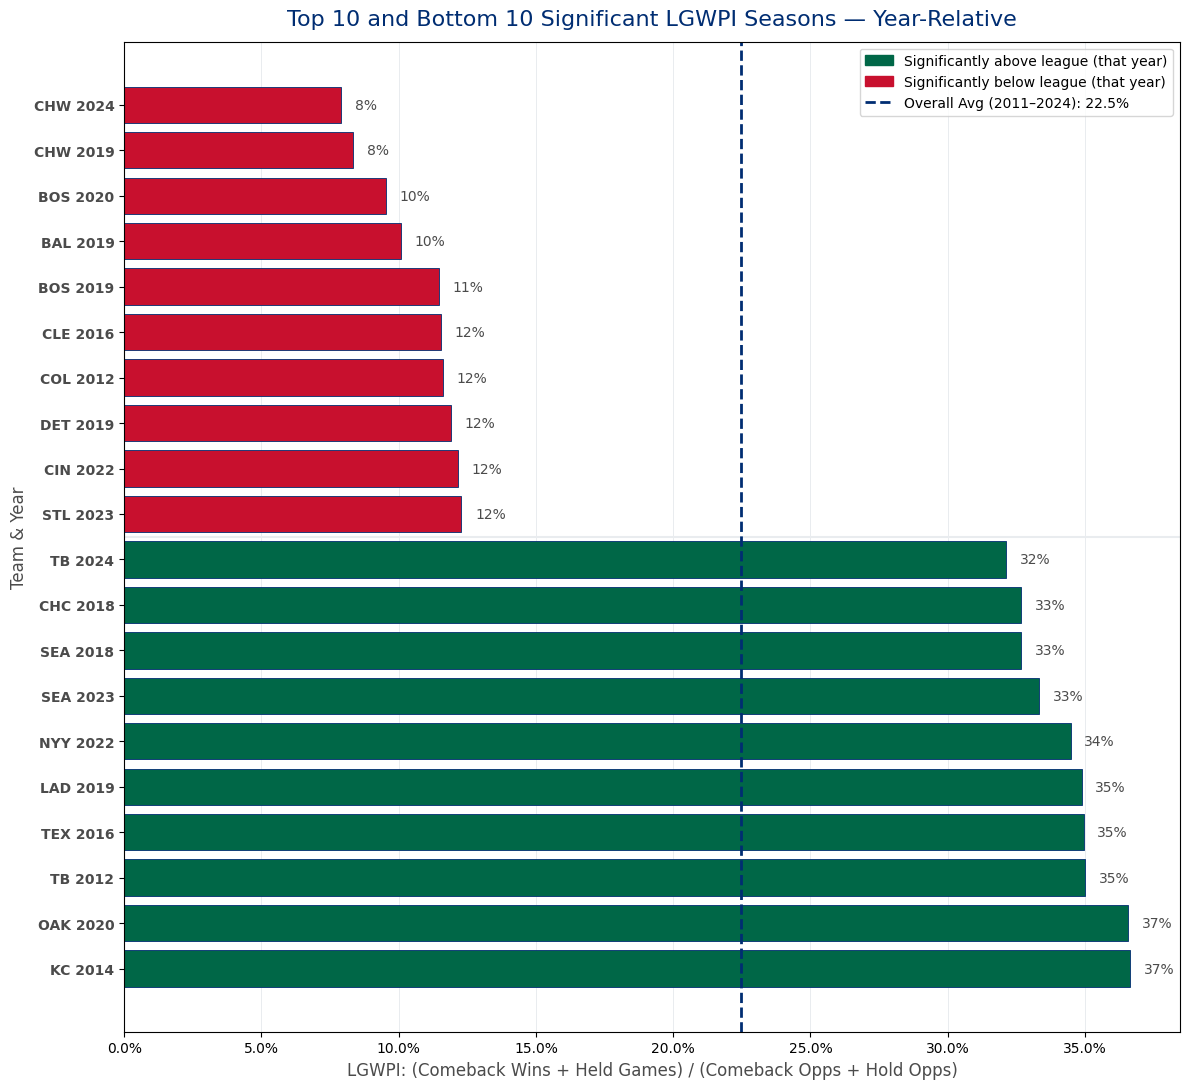

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches

NAVY = "#002D72"
RED = "#C8102E"
GREEN = "#006747"
LTGRAY = "#E9ECEF"
DARKGRAY = "#4B4B4B"
WHITE = "#FFFFFF"

SIG_COL = "LGWPI_weighted_sig_year"

# Basic validation
required_cols = {"team", "year", "LGWPI_weighted", SIG_COL}
missing = required_cols - set(data_team.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Ensure types
df = data_team.copy()
df["LGWPI_weighted"] = pd.to_numeric(df["LGWPI_weighted"], errors="coerce")
df[SIG_COL] = pd.to_numeric(df[SIG_COL], errors="coerce")
df = df.dropna(subset=["LGWPI_weighted"])

# Overall average (all seasons)
overall_mean = df["LGWPI_weighted"].mean()

# Filter significant seasons (vs league in the SAME YEAR)
sig_pos = df[df[SIG_COL] == 1].copy()
sig_neg = df[df[SIG_COL] == -1].copy()

# Top 10 (best) and Bottom 10 (worst) — note: bottom uses ASCENDING
top10 = sig_pos.sort_values("LGWPI_weighted", ascending=False).head(10)

bot10 = sig_neg.sort_values("LGWPI_weighted", ascending=True).head(10)
bot10 = bot10.sort_values("LGWPI_weighted", ascending=False)

# Labels
top10["label"] = top10["team"].astype(str) + " " + top10["year"].astype(str)
bot10["label"] = bot10["team"].astype(str) + " " + bot10["year"].astype(str)

# Combine and colors
plot_df = pd.concat([top10, bot10], axis=0).reset_index(drop=True)
plot_df["color"] = np.where(plot_df[SIG_COL] == 1, GREEN, RED)

# ---- Plot ----
fig_height = max(6, 0.45 * len(plot_df) + 2)
fig, ax = plt.subplots(figsize=(12, fig_height), facecolor=WHITE)
ax.set_axisbelow(True)
ax.grid(axis="x", color=LTGRAY, linewidth=0.7)

y = np.arange(len(plot_df))
ax.barh(y, plot_df["LGWPI_weighted"], color=plot_df["color"], edgecolor=NAVY, linewidth=0.6)

ax.set_yticks(y)
ax.set_yticklabels(plot_df["label"], color=DARKGRAY, fontsize=10, fontweight="bold")

# Value labels
for i, val in enumerate(plot_df["LGWPI_weighted"]):
    ax.text(val + 0.005, i, f"{val:.0%}", va="center", ha="left", fontsize=10, color=DARKGRAY)

# Separator between top and bottom
if len(top10) and len(bot10):
    ax.axhline(len(top10) - 0.5, color=LTGRAY, linewidth=1.5)

# Overall average line with legend handle
avg_line = ax.axvline(overall_mean, color=NAVY, linestyle="--", linewidth=2,
                      label=f"Overall Avg (2011–2024): {overall_mean:.1%}")

# Axes & titles
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("LGWPI: (Comeback Wins + Held Games) / (Comeback Opps + Hold Opps)",
              color=DARKGRAY, fontsize=12)
ax.set_ylabel("Team & Year", color=DARKGRAY, fontsize=12)
ax.set_title("Top 10 and Bottom 10 Significant LGWPI Seasons — Year-Relative",
             fontsize=16, color=NAVY, pad=12)

# Legend (clarify year-relative significance)
legend_patches = [
    mpatches.Patch(color=GREEN, label="Significantly above league (that year)"),
    mpatches.Patch(color=RED,   label="Significantly below league (that year)"),
    avg_line
]
ax.legend(handles=legend_patches, frameon=True, loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()


In [243]:
data_team['win_p'] = data_team['final_win']/data_team["total_games"]
corr_value = data_team['LGWPI_weighted'].corr(data_team['win_p'], method='pearson')
print(f"Pearson correlation between LGWPI and Win%: {corr_value:.3f}")

Pearson correlation between LGWPI and Win%: 0.541


#### How Often Did Division Winners Have a Significantly Higher LGCI? (2011–2024)

In [244]:
folder_path = "/Users/lancesanterre/interview/mlb_division_winners_2011_2024.csv"
winners = pd.read_csv(folder_path)

winners_long = winners.melt(id_vars=["Year"], value_name="winner_name") \
                      .drop(columns=["variable"])

team_map = {
    "NYY": "Yankees", "BOS": "Red Sox", "TBR": "Rays", "TOR": "Blue Jays", "BAL": "Orioles",
    "CLE": "Guardians", "CHW": "White Sox", "DET": "Tigers", "KCR": "Royals", "MIN": "Twins",
    "HOU": "Astros", "TEX": "Rangers", "LAA": "Angels", "OAK": "Athletics",
    "ATL": "Braves", "NYM": "Mets", "PHI": "Phillies", "WSN": "Nationals", "MIA": "Marlins",
    "CHC": "Cubs", "STL": "Cardinals", "MIL": "Brewers", "CIN": "Reds", "PIT": "Pirates",
    "LAD": "Dodgers", "SFG": "Giants", "ARI": "Diamondbacks", "SDP": "Padres", "COL": "Rockies"
}

# Fix CLE name for pre-2022
def map_team(abbrev, year):
    if abbrev == "CLE" and year < 2022:
        return "Indians"
    return team_map.get(abbrev, abbrev)

# --- Filter predictions ---
preds = data_team[data_team["LGWPI_weighted_sig_year"] == 1][["team", "year"]].copy()
preds["team_name"] = preds.apply(lambda r: map_team(r["team"], r["year"]), axis=1)

# --- Check correctness ---
preds = preds.merge(winners_long, left_on=["year", "team_name"], right_on=["Year", "winner_name"], how="left")
preds["correct"] = preds["winner_name"].notna()

# --- Score ---
accuracy = preds["correct"].mean()
print("Precentage of Division Winners with Significant LGWPI Advantage (2011–2024)")
print(f"Correct Picks: {preds['correct'].sum()} / {len(preds)} ({accuracy:.1%})")



Precentage of Division Winners with Significant LGWPI Advantage (2011–2024)
Correct Picks: 9 / 19 (47.4%)


**Insight:** From 2011–2024, teams with a significantly higher LGWPI won their division 47.4% of the time.


In [245]:
top_bottom_per_year = []

for year, group in data_team.groupby("year"):
    group_sorted = group.sort_values("LGWPI_weighted", ascending=False)
    
    top_team = group_sorted.iloc[0]
    bottom_team = group_sorted.iloc[-5]
    
    top_bottom_per_year.append({
        "year": year,
        "top_team": top_team["team"],
        "top_team wins": top_team['final_win'],
        "top_LGWPI_weighted": top_team["LGWPI_weighted"],
        "bottom_team": bottom_team["team"],
        "bottom_team wins": bottom_team['final_win'],
        "bottom_LGWPI_weighted": bottom_team["LGWPI_weighted"]
    })

# Create DataFrame for display
top_bottom_df = pd.DataFrame(top_bottom_per_year)

In [246]:
top_bottom_df

,year,top_team,top_team wins,top_LGWPI_weighted,bottom_team,bottom_team wins,bottom_LGWPI_weighted
0,2011,NYY,97,0.291667,BAL,69,0.180328
1,2012,TB,90,0.350000,MIA,69,0.170732
2,2013,LAD,92,0.281250,SD,76,0.191919
3,2014,KC,89,0.366337,CHC,73,0.194444
4,2015,CHW,76,0.311321,DET,74,0.181818
5,2016,TEX,95,0.349515,TB,68,0.189189
6,2017,LAD,104,0.292135,CIN,68,0.165138
7,2018,SEA,89,0.326733,KC,58,0.157895
8,2019,LAD,106,0.348837,WSN,93,0.131868
9,2020,OAK,36,0.365854,ATL,35,0.150000


### Calculating LGWPI_weighted & Testing for Significance

$$
\text{LGWPI}_{\text{weighted}} =
\sum_{i=1}^{n}
\frac{
w_{\text{CW}} \cdot \text{Comeback Wins}_i + w_{\text{HG}} \cdot \text{Held Games}_i
}{
\text{Comeback Opportunities}_i + \text{Hold Opportunities}_i
}
$$
#### We use a significance level of α = 0.05 to determine whether a team's LGWPI is statistically different from the league average.


In [247]:
folder_path = "/Users/lancesanterre/interview/data_aq/team_data/all_teams_yearly_summary.csv"
data_team = pd.read_csv(folder_path)

# --- Ensure numeric + handle NaNs ---
num_cols = ["comeback_wins", "held_game", "is_comeback_scenario", "lead_1_2_runs_6th", "final_win"]
for c in num_cols:
    if c not in data_team.columns:
        raise KeyError(f"Missing required column: {c}")
    data_team[c] = pd.to_numeric(data_team[c], errors="coerce").fillna(0)

# Aliases
CW = data_team["comeback_wins"]          # comeback wins
HG = data_team["held_game"]              # held games
CO = data_team["is_comeback_scenario"]   # comeback opportunities
HO = data_team["lead_1_2_runs_6th"]      # hold opportunities (lead by 1–2 after 6th)

# --- Weighting ---
w_CW = 2   # weight for comeback wins
w_HG = 1   # weight for held games

# Weighted LGWPI formula
den = CO + HO
num = (w_CW * CW) + (w_HG * HG)
data_team["LGWPI_weighted"] = np.where(den > 0, num / den, np.nan)

# Sort results
data_team_sorted = data_team.sort_values(["LGWPI_weighted"], ascending=False, na_position="last")

print("Best Weighted LGWPI")
print(
    data_team_sorted[["team", "year", "final_win", "comeback_wins", "held_game", "LGWPI_weighted"]]
      .head(10)
      .to_string(index=False,
                 formatters={"LGWPI_weighted": "{:.3f}".format})
)

print("\nWorst Weighted LGWPI")
print(
    data_team_sorted[["team", "year", "final_win", "comeback_wins", "held_game", "LGWPI_weighted"]]
      .tail(10)
      .to_string(index=False,
                 formatters={"LGWPI_weighted": "{:.3f}".format})
)


Best Weighted LGWPI
team  year  final_win  comeback_wins  held_game LGWPI_weighted
 OAK  2020         36              6          9          0.512
 LAD  2019        106             14         16          0.512
 LAD  2020         43              5          4          0.500
 TEX  2016         95             15         21          0.495
 DET  2024         86             18         18          0.478
 MIN  2023         87             16         17          0.476
  KC  2014         89             11         26          0.475
 BAL  2012         93             16         16          0.475
 NYY  2022         99             11         19          0.471
  SF  2021        107             14         13          0.471

Worst Weighted LGWPI
team  year  final_win  comeback_wins  held_game LGWPI_weighted
 DET  2019         47              5         10          0.159
 STL  2023         71              4         10          0.158
 COL  2012         64              4          9          0.152
 BOS  2019   

### Lets now find teams that are Significally Better or Worse than the rest of the league
#### Running a hypostisis test z test for this 

In [248]:
# --- Build year-relative significance for LGWPI_weighted ---

w_CW, w_HG = 2.0, 1.0
alpha = 0.05

# Ensure numeric
for c in ["comeback_wins","held_game","is_comeback_scenario","lead_1_2_runs_6th"]:
    data_team[c] = pd.to_numeric(data_team[c], errors="coerce").fillna(0)

# Weighted successes/trials per team-year row
data_team["w_success"] = w_CW*data_team["comeback_wins"] + w_HG*data_team["held_game"]
data_team["w_trials"]  = w_CW*data_team["is_comeback_scenario"] + w_HG*data_team["lead_1_2_runs_6th"]

# LGWPI_weighted value (for plotting)
den = (data_team["is_comeback_scenario"] + data_team["lead_1_2_runs_6th"])
num = (w_CW*data_team["comeback_wins"] + w_HG*data_team["held_game"])
data_team["LGWPI_weighted"] = np.where(den > 0, num/den, np.nan)

# League totals per YEAR
yr_totals = (data_team.groupby("year")[["w_success","w_trials"]]
                        .sum(numeric_only=True)
                        .rename(columns={"w_success":"yr_success","w_trials":"yr_trials"}))
df = data_team.merge(yr_totals, on="year", how="left")

# Helper (uses your existing two_prop_ztest)
def safe_z(c1,n1,c2,n2):
    if n1 <= 0 or n2 <= 0: return np.nan, np.nan
    return two_prop_ztest(c1, n1, c2, n2)

# Compute significance vs league-minus-team for that year
sig_year, z_list, p_list = [], [], []
for _, r in df.iterrows():
    c1, n1 = float(r["w_success"]), float(r["w_trials"])
    c2, n2 = float(r["yr_success"] - c1), float(r["yr_trials"] - n1)
    z, p = safe_z(c1, n1, c2, n2)
    z_list.append(z); p_list.append(p)
    if np.isnan(p): s = 0
    elif p < alpha: s = 1 if (c1/n1) > (c2/n2) else -1
    else: s = 0
    sig_year.append(s)

df["LGWPI_weighted_z_year"]   = z_list
df["LGWPI_weighted_p_year"]   = p_list
df["LGWPI_weighted_sig_year"] = sig_year

# Replace data_team with augmented frame
data_team = df


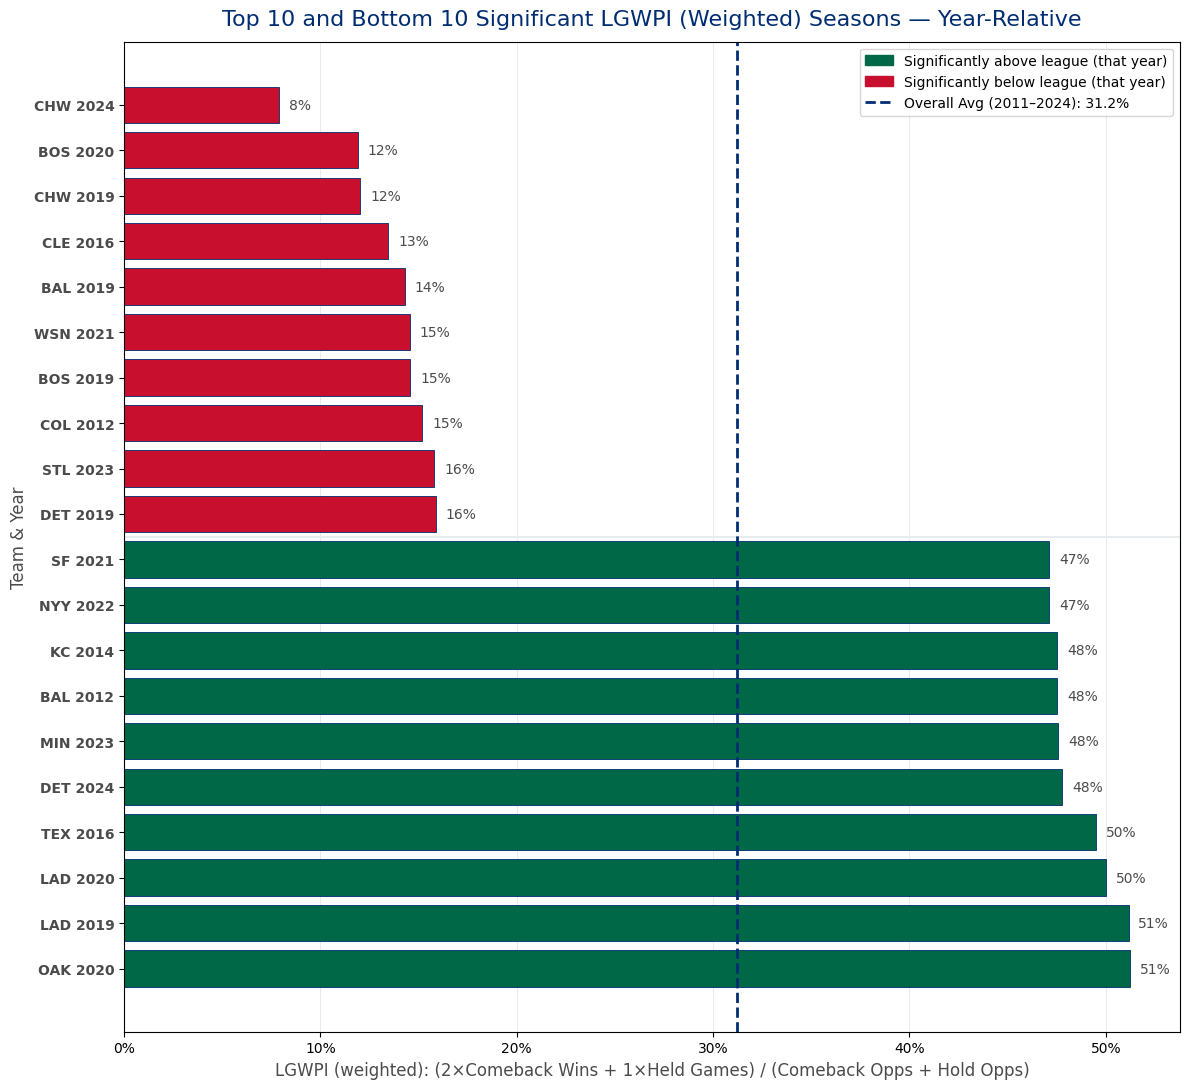

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches

NAVY = "#002D72"
RED = "#C8102E"
GREEN = "#006747"
LTGRAY = "#E9ECEF"
DARKGRAY = "#4B4B4B"
WHITE = "#FFFFFF"

SIG_COL = "LGWPI_weighted_sig_year"

# Basic validation
required_cols = {"team", "year", "LGWPI_weighted", SIG_COL}
missing = required_cols - set(data_team.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Ensure types
df = data_team.copy()
df["LGWPI_weighted"] = pd.to_numeric(df["LGWPI_weighted"], errors="coerce")
df[SIG_COL] = pd.to_numeric(df[SIG_COL], errors="coerce")
df = df.dropna(subset=["LGWPI_weighted"])

# Overall average (all seasons)
overall_mean = df["LGWPI_weighted"].mean()

# Filter significant seasons (vs league in the SAME YEAR)
sig_pos = df[df[SIG_COL] == 1].copy()
sig_neg = df[df[SIG_COL] == -1].copy()

# Top 10 (best) and Bottom 10 (worst) — note: bottom uses ASCENDING
top10 = sig_pos.sort_values("LGWPI_weighted", ascending=False).head(10)

bot10 = sig_neg.sort_values("LGWPI_weighted", ascending=True).head(10)
bot10 = bot10.sort_values("LGWPI_weighted", ascending=False)

# Labels
top10["label"] = top10["team"].astype(str) + " " + top10["year"].astype(str)
bot10["label"] = bot10["team"].astype(str) + " " + bot10["year"].astype(str)

# Combine and colors
plot_df = pd.concat([top10, bot10], axis=0).reset_index(drop=True)
plot_df["color"] = np.where(plot_df[SIG_COL] == 1, GREEN, RED)

# ---- Plot ----
fig_height = max(6, 0.45 * len(plot_df) + 2)
fig, ax = plt.subplots(figsize=(12, fig_height), facecolor=WHITE)
ax.set_axisbelow(True)
ax.grid(axis="x", color=LTGRAY, linewidth=0.7)

y = np.arange(len(plot_df))
ax.barh(y, plot_df["LGWPI_weighted"], color=plot_df["color"], edgecolor=NAVY, linewidth=0.6)

ax.set_yticks(y)
ax.set_yticklabels(plot_df["label"], color=DARKGRAY, fontsize=10, fontweight="bold")

# Value labels
for i, val in enumerate(plot_df["LGWPI_weighted"]):
    ax.text(val + 0.005, i, f"{val:.0%}", va="center", ha="left", fontsize=10, color=DARKGRAY)

# Separator between top and bottom
if len(top10) and len(bot10):
    ax.axhline(len(top10) - 0.5, color=LTGRAY, linewidth=1.5)

# Overall average line with legend handle
avg_line = ax.axvline(overall_mean, color=NAVY, linestyle="--", linewidth=2,
                      label=f"Overall Avg (2011–2024): {overall_mean:.1%}")

# Axes & titles
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("LGWPI (weighted): (2×Comeback Wins + 1×Held Games) / (Comeback Opps + Hold Opps)",
              color=DARKGRAY, fontsize=12)
ax.set_ylabel("Team & Year", color=DARKGRAY, fontsize=12)
ax.set_title("Top 10 and Bottom 10 Significant LGWPI (Weighted) Seasons — Year-Relative",
             fontsize=16, color=NAVY, pad=12)

# Legend (clarify year-relative significance)
legend_patches = [
    mpatches.Patch(color=GREEN, label="Significantly above league (that year)"),
    mpatches.Patch(color=RED,   label="Significantly below league (that year)"),
    avg_line
]
ax.legend(handles=legend_patches, frameon=True, loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()


In [250]:
data_team['win_p'] = data_team['final_win']/data_team["total_games"]
corr_value = data_team['LGWPI_weighted'].corr(data_team['win_p'], method='pearson')
print(f"Pearson correlation between LGWPI_weighted and Win%: {corr_value:.3f}")

Pearson correlation between LGWPI_weighted and Win%: 0.582


#### How Often Did Division Winners Have a Significantly Higher LGCI? (2011–2024)

In [251]:
folder_path = "/Users/lancesanterre/interview/mlb_division_winners_2011_2024.csv"
winners = pd.read_csv(folder_path)

winners_long = winners.melt(id_vars=["Year"], value_name="winner_name") \
                      .drop(columns=["variable"])

# --- Map abbreviations to winner names ---
team_map = {
    "NYY": "Yankees", "BOS": "Red Sox", "TBR": "Rays", "TOR": "Blue Jays", "BAL": "Orioles",
    "CLE": "Guardians", "CHW": "White Sox", "DET": "Tigers", "KCR": "Royals", "MIN": "Twins",
    "HOU": "Astros", "TEX": "Rangers", "LAA": "Angels", "OAK": "Athletics",
    "ATL": "Braves", "NYM": "Mets", "PHI": "Phillies", "WSN": "Nationals", "MIA": "Marlins",
    "CHC": "Cubs", "STL": "Cardinals", "MIL": "Brewers", "CIN": "Reds", "PIT": "Pirates",
    "LAD": "Dodgers", "SFG": "Giants", "ARI": "Diamondbacks", "SDP": "Padres", "COL": "Rockies"
}

# Fix CLE name for pre-2022
def map_team(abbrev, year):
    if abbrev == "CLE" and year < 2022:
        return "Indians"
    return team_map.get(abbrev, abbrev)

# --- Filter predictions ---
preds = data_team[data_team["LGWPI_weighted_sig_year"] == 1][["team", "year"]].copy()
preds["team_name"] = preds.apply(lambda r: map_team(r["team"], r["year"]), axis=1)

# --- Check correctness ---
preds = preds.merge(winners_long, left_on=["year", "team_name"], right_on=["Year", "winner_name"], how="left")
preds["correct"] = preds["winner_name"].notna()

# --- Score ---
accuracy = preds["correct"].mean()
print("Precentage of Division Winners with Significant LGCI Advantage (2011–2024)")
print(f"Correct Picks: {preds['correct'].sum()} / {len(preds)} ({accuracy:.1%})")



Precentage of Division Winners with Significant LGCI Advantage (2011–2024)
Correct Picks: 21 / 40 (52.5%)


**Insight:** From 2011–2024, teams with a significantly higher LGWPI_weighted won their division 52.5% of the time.


In [252]:
top_bottom_per_year = []

for year, group in data_team.groupby("year"):
    group_sorted = group.sort_values("LGWPI_weighted", ascending=False)
    
    top_team = group_sorted.iloc[0]
    bottom_team = group_sorted.iloc[-1]
    
    top_bottom_per_year.append({
        "year": year,
        "top_team": top_team["team"],
        "top_team wins": top_team['final_win'],
        "top_LGWPI_weighted": top_team["LGWPI_weighted"],
        "bottom_team": bottom_team["team"],
        "bottom_team wins": bottom_team['final_win'],
        "bottom_LGWPI_weighted": bottom_team["LGWPI_weighted"]
    })

# Create DataFrame for display
top_bottom_df = pd.DataFrame(top_bottom_per_year)

In [253]:
top_bottom_df

,year,top_team,top_team wins,top_LGWPI_weighted,bottom_team,bottom_team wins,bottom_LGWPI_weighted
0,2011,TOR,81,0.414141,HOU,56,0.221239
1,2012,BAL,93,0.475248,COL,64,0.151786
2,2013,STL,97,0.393617,HOU,51,0.196581
3,2014,KC,89,0.475248,LAD,94,0.202020
4,2015,STL,100,0.432990,MIA,71,0.223301
5,2016,TEX,95,0.495146,CLE,69,0.134615
6,2017,SEA,78,0.414414,DET,63,0.187500
7,2018,SEA,89,0.455446,MIA,63,0.169643
8,2019,LAD,106,0.511628,CHW,72,0.120370
9,2020,OAK,36,0.512195,BOS,24,0.119048
